In [1]:
import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
def load_datasets():
    """Load all datasets and return them as dataframes."""
    current_dir = os.getcwd()
    ROOT_PATH = os.path.dirname(current_dir)
    sys.path.insert(1, ROOT_PATH)
    sys.path.insert(1, current_dir)
    import root

    train = pd.read_pickle(root.DIR_DATA_STAGE + 'generation.pkl')
    client = pd.read_pickle(root.DIR_DATA_STAGE + 'client.pkl')
    historical_weather = pd.read_pickle(root.DIR_DATA_STAGE + 'historical_weather.pkl')
    electricity_prices = pd.read_pickle(root.DIR_DATA_STAGE + 'electricity_prices.pkl')
    gas_prices = pd.read_pickle(root.DIR_DATA_STAGE + 'gas_prices.pkl')  

    return  train, client, historical_weather, electricity_prices, gas_prices


def add_time_series_col(client, historical_weather, electricity_prices, gas_prices):
    """Add column with date where data is available."""

    client['datetime'] = pd.to_datetime(client['date']) + pd.Timedelta(days=3)
    historical_weather['datetime'] += pd.Timedelta(days=2)
    electricity_prices['datetime'] = pd.to_datetime(electricity_prices['forecast_date']) + pd.Timedelta(days=1)
    gas_prices['datetime'] = pd.to_datetime(gas_prices['forecast_date']) + pd.Timedelta(days=1)

    # Drop unnecessary columns after date adjustments
    client = client.drop(['date'], axis=1)
    electricity_prices = electricity_prices.drop(['forecast_date'], axis=1)
    gas_prices = gas_prices.drop(['forecast_date'], axis=1)

    return client, historical_weather, electricity_prices, gas_prices


def merge_datasets(train, client, historical_weather, electricity_prices, gas_prices):
    """Merge DataFrames train, client, historical weather, gas prices and electricity prices based on the datetime column."""
    merged = train.merge(historical_weather, on='datetime', how='left') \
                  .merge(electricity_prices, on='datetime', how='left')
    
    # Add dt.floor('D')
    merged['date'] = merged['datetime'].dt.floor('D')
    client['date'] = client['datetime'].dt.floor('D')
    client = client.drop('datetime', axis=1)
    gas_prices['date'] = gas_prices['datetime'].dt.floor('D')
    gas_prices = gas_prices.drop('datetime', axis=1)

    merged = merged.merge(client, on='date', how='outer') \
                   .merge(gas_prices, on='date', how='outer')

    #dreop unnecessary columns
    merged = merged.drop(['date'], axis=1)
    
    return merged


def reorder_columns(df, column_order=None):
    """Reorder columns of the DataFrame."""
    if column_order == None:
        column_order = [
            'datetime', 'target', 'temperature', 'dewpoint', 'rain', 'snowfall',
            'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 
            'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 
            'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation',
            'lowest_price_per_mwh', 'highest_price_per_mwh', 'euros_per_mwh','eic_count', 'installed_capacity'
            ]
    return df[column_order]


def save_datasets_to_pickle(datasets, paths=None):
    """Save each dataset in datasets list to the corresponding path in paths list as a pickle file."""
    if paths == None:
        import root
        paths = [
            root.DIR_DATA_STAGE + 'merged_df.pkl',
        ]

    # Create folders if not exists
    for path in paths:
        os.makedirs(os.path.dirname(path), exist_ok=True)

    # Save each dataset to its respective path
    for dataset, path in zip(datasets, paths):
        dataset.to_pickle(path)


def drop_first_3_days(df, column, threshold_column, threshold_nans=70):
    """Drop first 3 days of the dataset if the threshold is exceeded."""
    # Count null values in the threshold column
    nulos = df[threshold_column].isna().sum()
    
    # If the threshold is exceeded drop the first 3 days
    if nulos > threshold_nans:
        # Initial date
        fecha_minima = df[column].min()
        # Limit day
        limite = fecha_minima + pd.Timedelta(days=3)
        # Filter df
        df = df[df[column] >= limite]
    
    return df


def feature_selection(df):
    cols_2_drop = [ 'dewpoint','cloudcover_low','cloudcover_mid', 
                   'cloudcover_high','direct_solar_radiation',
                   'diffuse_radiation', 'lowest_price_per_mwh',
                   'highest_price_per_mwh','eic_count']
    df.drop(columns = cols_2_drop, axis = 1, inplace = True)
    return df


def set_datetime_index(df):
    df = df.set_index('datetime')
    df = df.asfreq('h')
    return df


def merge():
     # Read datasets
    train, client, historical_weather, electricity_prices, gas_prices = load_datasets()

    # Prepare date columns for merging
    client, historical_weather, electricity_prices, gas_prices = add_time_series_col(client, historical_weather, electricity_prices, gas_prices)

    # Merge datasets
    merged = merge_datasets(train, client, historical_weather, electricity_prices, gas_prices)
    
    # Reorder dataset columns
    merged = reorder_columns(merged)
    
    # Drop first three days
    merged = drop_first_3_days(merged, 'datetime','installed_capacity')

    # Set datetime index
    merged = set_datetime_index(merged)

    # Save dataset to pickle file
    save_datasets_to_pickle([merged])
    
    return merged

In [3]:
datos = merge()

In [4]:
nuevos_nombres = {
    'target': 'Generación',
    'temperature': 'Temperatura',
    'dewpoint': 'Punto de rocio',
    'rain': 'Lluvia',
    'snowfall': 'Nieve',
    'surface_pressure': 'Presion',
    'cloudcover_total': 'Nubosidad total',
    'cloudcover_low': 'Nubosidad baja',
    'cloudcover_mid': 'Nubosidad media',
    'cloudcover_high': 'Nubosidad alta',
    'windspeed_10m': 'Vel.Viento',
    'winddirection_10m': 'Dir.Viento',
    'shortwave_radiation': 'Radiacion onda corta',
    'direct_solar_radiation': 'Radiacion directa',
    'diffuse_radiation': 'Radiacion difusa',
    'lowest_price_per_mwh': 'Precio min MWh',
    'highest_price_per_mwh': 'Precio max Mwh',
    'euros_per_mwh': 'Euros MWh',
    'eic_count': 'Puntos de consumo',
    'installed_capacity': 'Capacidad instalada'
}

In [5]:
datos = datos.rename(columns=nuevos_nombres)

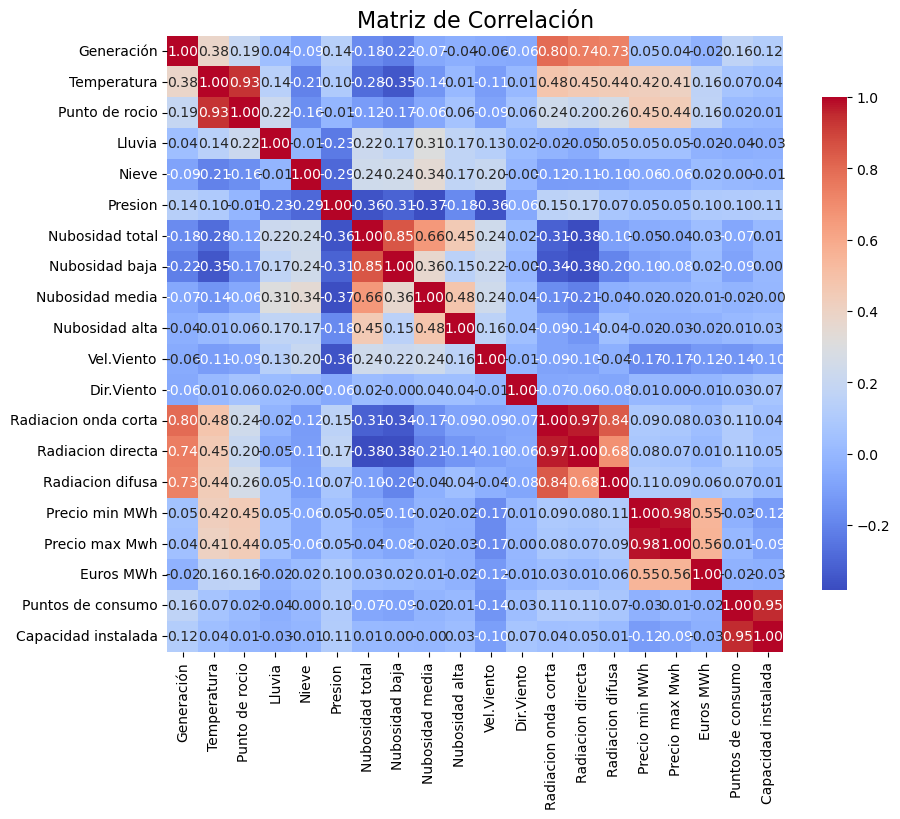

In [7]:
correlation_matrix = datos.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

In [91]:
datos.columns

Index(['Generación', 'Temperatura', 'Punto de rocio', 'Lluvia', 'Nieve',
       'Presion', 'Nubosidad total', 'Nubosidad baja', 'Nubosidad media',
       'Nubosidad alta', 'Vel.Viento', 'Dir.Viento', 'Radiacion onda corta',
       'Radiacion directa', 'Radiacion difusa', 'Precio min MWh',
       'Precio max Mwh', 'Euros MWh', 'Puntos de consumo',
       'Capacidad instalada'],
      dtype='object')

# Filtro install capacity eic count

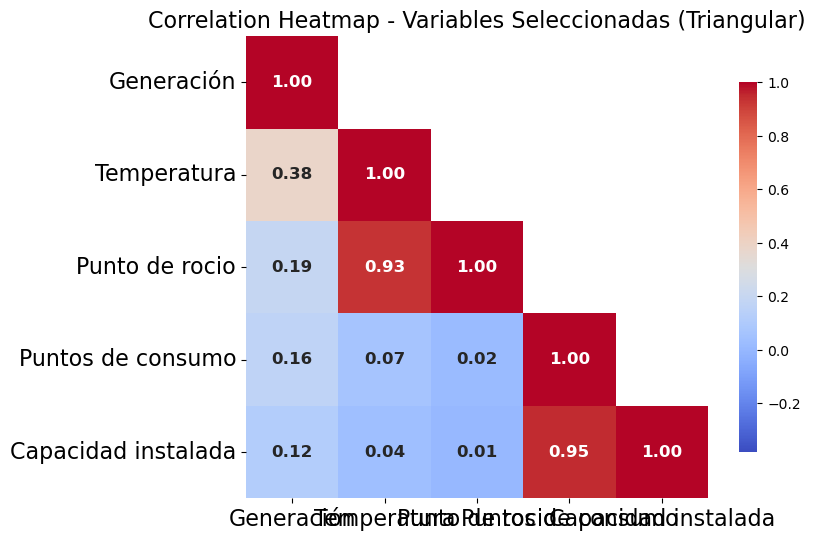

In [92]:
variables_interes = ['Generación','Temperatura', 'Punto de rocio','Puntos de consumo',
       'Capacidad instalada']  # reemplaza con los nombres de las variables que te interesan

# Filtrar el DataFrame solo con esas variables
datos_interes = datos[variables_interes]

correlation_submatrix = correlation_matrix.loc[variables_interes, variables_interes]

# Obtener los valores mínimo y máximo de la matriz completa
vmin = correlation_matrix.min().min()
vmax = correlation_matrix.max().max()

mask = np.triu(np.ones_like(correlation_submatrix, dtype=bool),k=1)

# Graficar el mapa de calor triangular
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_submatrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, vmin=vmin, vmax=vmax, mask=mask, 
            annot_kws={"size": 12, "weight": "bold"})
plt.xticks(rotation=0,fontsize=16)  # Rota las etiquetas del eje X a 90 grados (perpendicular)
plt.yticks(rotation=0,fontsize=16)   # Mantiene las etiquetas del eje Y de forma horizontal
plt.title('Correlation Heatmap - Variables Seleccionadas (Triangular)', fontsize=16)
plt.show()

In [93]:
datos.columns

Index(['Generación', 'Temperatura', 'Punto de rocio', 'Lluvia', 'Nieve',
       'Presion', 'Nubosidad total', 'Nubosidad baja', 'Nubosidad media',
       'Nubosidad alta', 'Vel.Viento', 'Dir.Viento', 'Radiacion onda corta',
       'Radiacion directa', 'Radiacion difusa', 'Precio min MWh',
       'Precio max Mwh', 'Euros MWh', 'Puntos de consumo',
       'Capacidad instalada'],
      dtype='object')

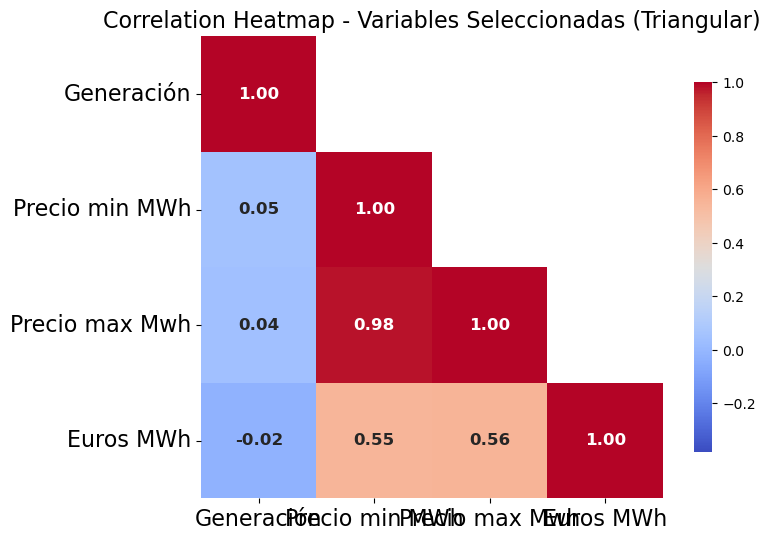

In [94]:
variables_interes = ['Generación','Precio min MWh',
       'Precio max Mwh', 'Euros MWh']  # reemplaza con los nombres de las variables que te interesan

# Filtrar el DataFrame solo con esas variables
datos_interes = datos[variables_interes]

correlation_submatrix = correlation_matrix.loc[variables_interes, variables_interes]

# Obtener los valores mínimo y máximo de la matriz completa
vmin = correlation_matrix.min().min()
vmax = correlation_matrix.max().max()

mask = np.triu(np.ones_like(correlation_submatrix, dtype=bool), k = 1)

# Graficar el mapa de calor triangular
# Graficar el mapa de calor triangular
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_submatrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, vmin=vmin, vmax=vmax, mask=mask, 
            annot_kws={"size": 12, "weight": "bold"})
plt.xticks(rotation=0,fontsize=16)  # Rota las etiquetas del eje X a 90 grados (perpendicular)
plt.yticks(rotation=0,fontsize=16)   # Mantiene las etiquetas del eje Y de forma horizontal
plt.title('Correlation Heatmap - Variables Seleccionadas (Triangular)', fontsize=16)
plt.show()

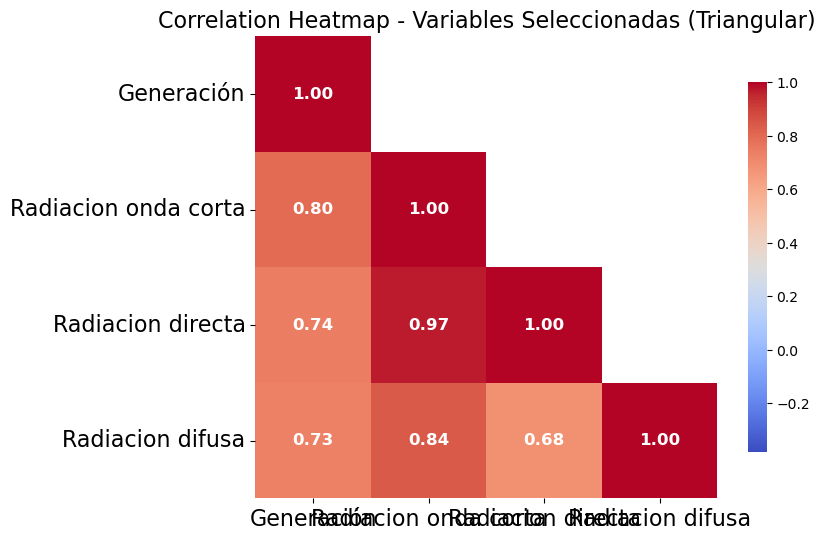

In [95]:
variables_interes = ['Generación','Radiacion onda corta',
       'Radiacion directa', 'Radiacion difusa'] # reemplaza con los nombres de las variables que te interesan

# Filtrar el DataFrame solo con esas variables
datos_interes = datos[variables_interes]

correlation_submatrix = correlation_matrix.loc[variables_interes, variables_interes]

# Obtener los valores mínimo y máximo de la matriz completa
vmin = correlation_matrix.min().min()
vmax = correlation_matrix.max().max()

mask = np.triu(np.ones_like(correlation_submatrix, dtype=bool), k = 1)

# Graficar el mapa de calor triangular
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_submatrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, vmin=vmin, vmax=vmax, mask=mask, 
            annot_kws={"size": 12, "weight": "bold"})
plt.xticks(rotation=0,fontsize=16)  # Rota las etiquetas del eje X a 90 grados (perpendicular)
plt.yticks(rotation=0,fontsize=16)   # Mantiene las etiquetas del eje Y de forma horizontal
plt.title('Correlation Heatmap - Variables Seleccionadas (Triangular)', fontsize=16)
plt.show()

In [96]:
datos.columns

Index(['Generación', 'Temperatura', 'Punto de rocio', 'Lluvia', 'Nieve',
       'Presion', 'Nubosidad total', 'Nubosidad baja', 'Nubosidad media',
       'Nubosidad alta', 'Vel.Viento', 'Dir.Viento', 'Radiacion onda corta',
       'Radiacion directa', 'Radiacion difusa', 'Precio min MWh',
       'Precio max Mwh', 'Euros MWh', 'Puntos de consumo',
       'Capacidad instalada'],
      dtype='object')

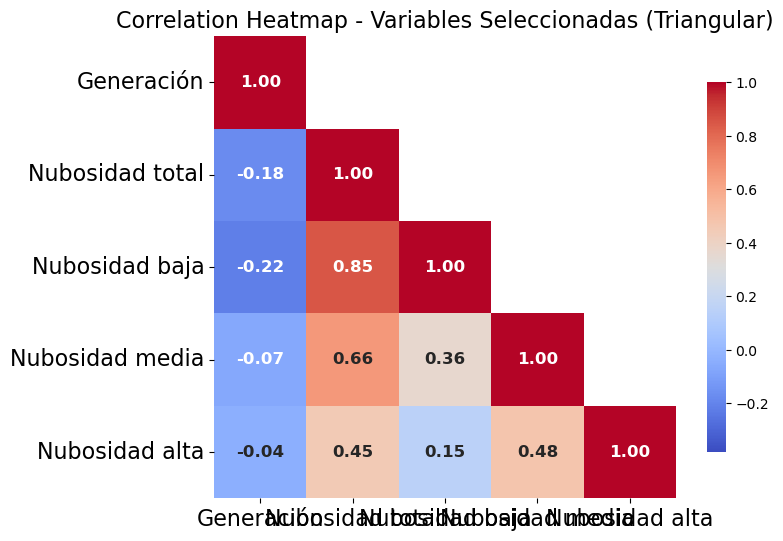

In [98]:
variables_interes = ['Generación','Nubosidad total', 'Nubosidad baja', 'Nubosidad media',
       'Nubosidad alta'] # reemplaza con los nombres de las variables que te interesan

# Filtrar el DataFrame solo con esas variables
datos_interes = datos[variables_interes]

correlation_submatrix = correlation_matrix.loc[variables_interes, variables_interes]

# Obtener los valores mínimo y máximo de la matriz completa
vmin = correlation_matrix.min().min()
vmax = correlation_matrix.max().max()

mask = np.triu(np.ones_like(correlation_submatrix, dtype=bool), k = 1)

# Graficar el mapa de calor triangular
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_submatrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, vmin=vmin, vmax=vmax, mask=mask, 
            annot_kws={"size": 12, "weight": "bold"})
plt.xticks(rotation=0,fontsize=16)  # Rota las etiquetas del eje X a 90 grados (perpendicular)
plt.yticks(rotation=0,fontsize=16)   # Mantiene las etiquetas del eje Y de forma horizontal
plt.title('Correlation Heatmap - Variables Seleccionadas (Triangular)', fontsize=16)
plt.show()

In [73]:
datos.columns

Index(['Generación', 'Temperatura', 'Punto de rocio', 'Lluvia', 'Nieve',
       'Presion', 'Nubación total', 'Nubación baja', 'Nubación media',
       'Nubación alta', 'Vel.Viento', 'Dir.Viento', 'Radiacion onda corta',
       'Radiacion directa', 'Radiacion difusa', 'Precio min MWh',
       'Precio maxi Mwh', 'Euros MWh', 'Puntos de consumo',
       'Capacidad instalada'],
      dtype='object')